In [1]:
# pip install nltk
# pip install google-genai
# pip install numpy
# pip install pandas
# pip install google-genai 
# pip install seaborn
# pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
from google import genai
from google.genai import types
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import time

In [ ]:
GEMINI_API_KEY = ['key1', 'key2', 'key3']

In [4]:
df = pd.read_csv('data/reviews.csv')

In [5]:
# Step 1: Drop irrelevant columns
df_clean = df[['content', 'score']].dropna()

# Step 2: Create sentiment labels
def label_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'  

df_clean['sentiment'] = df_clean['score'].apply(label_sentiment)

Sentiment is generated using score (User rating). <br><br>
1-2: Negative \
3: Neutral \
4-5: Positive 

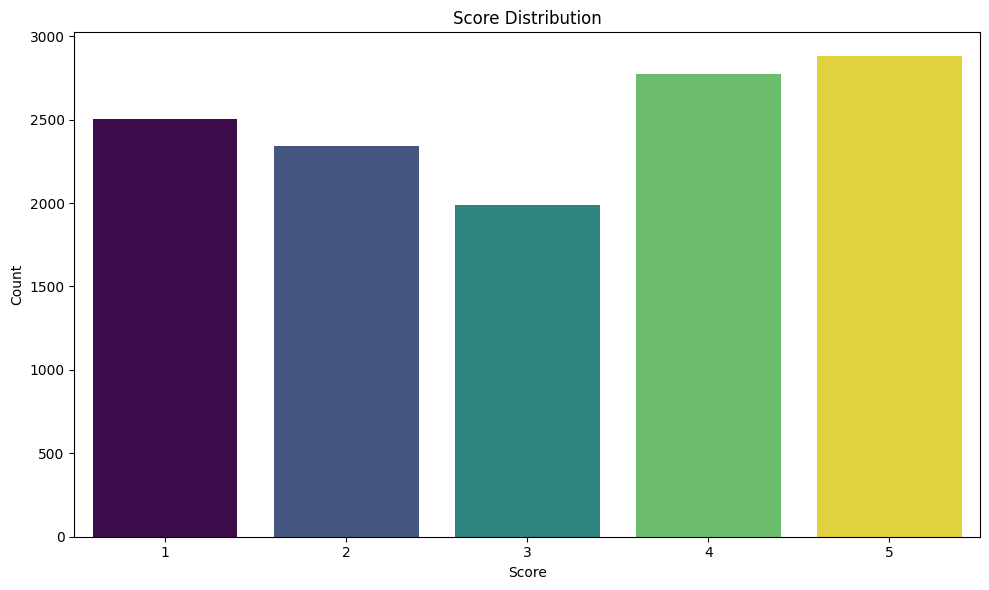

In [6]:
# Plot 2: Score distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='score', palette='viridis', hue = 'score', legend=False)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Overall, the distribution of score is pretty balanced. 

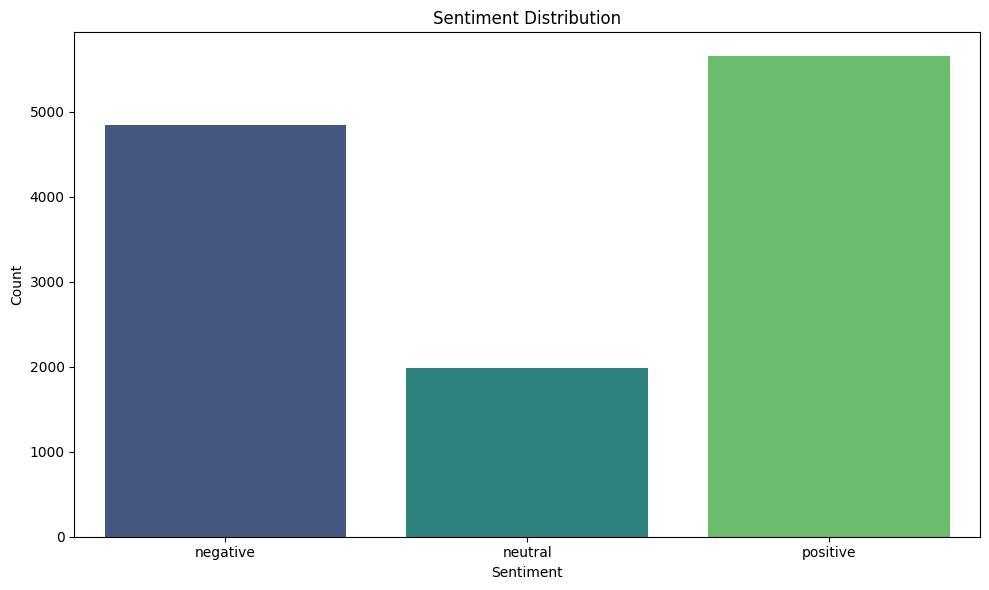

In [7]:
# Plot 1: Sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='sentiment', palette='viridis', hue = 'sentiment', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Because the distribution of user scores is quite uniform, there are more positive and negative reviews than there are neutral ones.

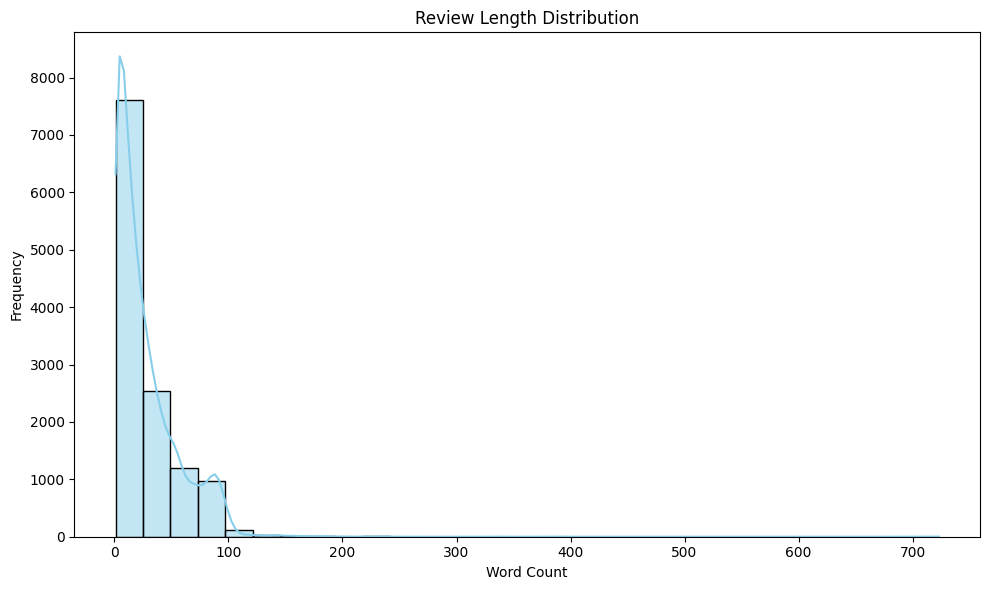

In [8]:
# Plot 3: Review length distribution
df_clean['review_length'] = df_clean['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['review_length'], bins=30, kde=True, color='skyblue')
plt.title('Review Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



Most reviews are quite short.

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load your data
df = df_clean

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Set up stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'<.*?>', ' ', text)  # remove HTML tags
    text = re.sub(r'http\S+|www\S+', ' ', text)  # remove URLs
    text = re.sub(r'[^a-z0-9\s!?]', ' ', text)  # keep !, ?, numbers
    tokens = text.split()
    # Keep negations like 'not', 'no', 'never'; remove mild stopwords
    filtered = [word for word in tokens if word not in stopwords.words('english') 
                or word in ['not', 'no', 'never']]
    lemmatized = [lemmatizer.lemmatize(word) for word in filtered]
    return ' '.join(lemmatized)

# Apply the function
df['clean_content'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/huyvu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/huyvu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Steps to text preprocessing: <br><br>

1. Convert text to lowercase.
2. Remove HTML tags and URLs.
3. Remove non-alphanumeric characters except for punctuation marks like "!" and "?".
4. Split text into individual words.
5. Remove common stopwords but keep negations.
6. Lemmatize the words (reduce them to their base form).

In [10]:
df

,content,score,sentiment,review_length,clean_content
0,I cannot open the app anymore,1,negative,6,cannot open app anymore
1,I have been begging for a refund from this app...,1,negative,19,begging refund app month nobody replying
2,Very costly for the premium version (approx In...,1,negative,36,costly premium version approx indian rupee 910...
3,"Used to keep me organized, but all the 2020 UP...",1,negative,44,used keep organized 2020 update made mess thin...
4,Dan Birthday Oct 28,1,negative,4,dan birthday oct 28
...,...,...,...,...,...
12490,"I really like the planner, it helps me achieve...",5,positive,24,really like planner help achieve task goal ave...
12491,😁****😁,5,positive,1,
12492,Very useful apps. You must try it,5,positive,7,useful apps must try
12493,Would pay for this if there were even more add...,5,positive,23,would pay even addition update absolutely love...


In [11]:
system_prompt = '''
You are given a JSON input containing an array of texts. Your task is to perform sentiment analysis on each text and produce an output array of the same length. Each element in the output array should be a sentiment label corresponding to the input text at the same index: 1 for positive sentiment, 0 for neutral sentiment, and -1 for negative sentiment.

Please process the input carefully, analyzing the sentiment of each text accurately.

# Steps
1. Parse the input JSON to extract the array of texts.
2. For each text, analyze the sentiment:
   - Assign 1 if the sentiment is clearly positive.
   - Assign 0 if the sentiment is neutral or mixed without clear positivity or negativity.
   - Assign -1 if the sentiment is clearly negative.
3. Construct an output array with the sentiment labels corresponding by position to the input texts.
4. Return the output array as an array.

# Output Format
Return an array of integers, each being 1, 0, or -1, corresponding to the sentiment analysis of the input texts by index.

# Examples
Input:
'["I love this product!", "It's okay, nothing special.", "This is terrible and disappointing."]'

Output:
[1, 0, -1]

# Notes
- Ensure the output length matches the input array length exactly.
- Focus on the overall sentiment of each individual text.
- If sentiment is ambiguous, default to neutral (0).
- You must give me the sentiment, not code to generate sentiment.
- Return the sentiment array and nothing else.
'''

def predict(batch: str, i: int):
    client = genai.Client(api_key=GEMINI_API_KEY[i])
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=batch,
        config=types.GenerateContentConfig(
            system_instruction=system_prompt,
            temperature=0.3,
        ),
    )
    return ast.literal_eval(response.text)

key = 0
batch_size = 20
batches = []
for i in range(0, len(df), batch_size):
    batches.append(list(df['content'][i:i+batch_size].values))

exception_count = 0
predicted_sentiment = []
count = 0
for batch in batches:
    temp_exception_count = 0
    count += 1
    print('Batch ', count)
    while True:
        key = (key + 1) % 3
        time.sleep(5)
        if temp_exception_count == 10:
            batch_prediction = list(np.random.randint(-1, 1, len(batch)).astype(int))
            break
        try:
            batch_prediction = predict(json.dumps(batch, ensure_ascii=False), key)
            assert(type(batch_prediction) == list)
            assert(len(batch_prediction)) == len(batch)
            break
        except:
            print('Exception occured. Trying again.')
            exception_count += 1
            temp_exception_count += 1
    predicted_sentiment += batch_prediction
    print('\n')


print('Total errors: ', exception_count)

Batch  1


Batch  2
Exception occured. Trying again.
Exception occured. Trying again.
Exception occured. Trying again.


Batch  3


Batch  4


Batch  5


Batch  6


Batch  7


Batch  8
Exception occured. Trying again.
Exception occured. Trying again.


Batch  9


Batch  10
Exception occured. Trying again.


Batch  11


Batch  12


Batch  13
Exception occured. Trying again.
Exception occured. Trying again.
Exception occured. Trying again.
Exception occured. Trying again.
Exception occured. Trying again.


Batch  14
Exception occured. Trying again.


Batch  15
Exception occured. Trying again.


Batch  16


Batch  17


Batch  18


Batch  19


Batch  20


Batch  21


Batch  22


Batch  23


Batch  24
Exception occured. Trying again.


Batch  25
Exception occured. Trying again.
Exception occured. Trying again.
Exception occured. Trying again.
Exception occured. Trying again.


Batch  26


Batch  27


Batch  28
Exception occured. Trying again.


Batch  29


Batch  30


Batch  31


Batch  32


In [18]:
len(predicted_sentiment)

12495

In [20]:
df['LLM_sentiment'] = predicted_sentiment 

In [27]:
df['sentiment'] = df['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})

In [33]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

ac = accuracy_score(df['sentiment'], df['LLM_sentiment'])
bac = balanced_accuracy_score(df['sentiment'], df['LLM_sentiment'])

In [34]:
print('Accuracy Score: ', ac)
print('Balanced accuracy Score: ', bac)

Accuracy Score:  0.7098839535814325
Balanced accuracy Score:  0.6479951110039167


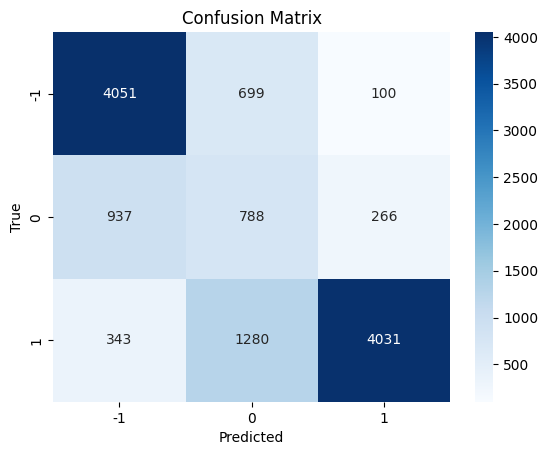

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df['sentiment'], df['LLM_sentiment'], labels=[-1, 0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['-1', '0', '1'],
            yticklabels=['-1', '0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

LLM predicts 'neutral' a lot. This may be because in the dataset there are a lot of reviews with no information at all, but with a very low or very high rating.